In [ ]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)
import numpy as np
from IPython.display import display
import email
import random
import string
import nltk
import os
from collections import Counter
import matplotlib.pyplot as plt


from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Enron/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip -uq "/content/gdrive/MyDrive/kaggle/enron/enron-email-dataset.zip" -d "/content/gdrive/MyDrive/kaggle/enron/"

In [ ]:

filepath = "/content/gdrive/MyDrive/kaggle/enron/emails.csv"
# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)
headers = [header for header in emails.columns]
print('Number of rows:', emails.shape[0])
print('Number of columns:', emails.shape[1])


Number of rows: 517401
Number of columns: 2


A significant part of this notebooks is based on: https://www.kaggle.com/donaldtfung/e-mail-categorization/notebook

In [ ]:
print('Emails Sample')
print(100*'-')
print(emails.loc[5]["message"])

Emails Sample
----------------------------------------------------------------------------------------------------
Message-ID: <30965995.1075863688265.JavaMail.evans@thyme>
Date: Thu, 31 Aug 2000 04:17:00 -0700 (PDT)
From: phillip.allen@enron.com
To: greg.piper@enron.com
Subject: Re: Hello
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Greg Piper
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Greg,

 How about either next Tuesday or Thursday?

Phillip


In [ ]:
def value_to_dict(dict, key, val):
  '''
  function to add value to
  dictionary
  '''
  if key in dict:
      values = dict.get(key)
      values.append(val)
      dict[key] = values
  else:
      dict[key] = [val]
  return dict

In [ ]:
def extract_head(df, header_names):
  
  head_set = dict()
  msgs = df["message"]
  for msg in msgs:
      str = email.message_from_string(msg)
      for item in header_names:
          header = str.get(item)
          value_to_dict(head_set,item,header) 
  return head_set

main_heads = ["Date", "Subject", "X-Folder", "X-From", "X-To"]    
headers = extract_head(emails, main_heads)

In [ ]:
len(headers["X-Folder"])

517401

In [ ]:
def extract_msg_body(df):
  '''
  function that extracts message body and
  from raw email
  '''
  msg_list = []
  for item in df["message"]:

    main_body = email.message_from_string(item).get_payload()     
    main_body_lwr = main_body.lower()
    msg_list.append(main_body_lwr)
  return msg_list
emails["Message-Body"] = extract_msg_body(emails)

In [ ]:
print('Sample Message Body:')
print(100*'-')
print(emails["Message-Body"][1000])
print(100*'-')

Sample Message Body:
----------------------------------------------------------------------------------------------------
lucy,

here is the rentroll.

my only questions are about #18, #25, and #37 missed rent.  any special 
reasons?

it looks like there are five vacancies #2,12,20a,35,40.  if you want to run 
an ad in the paper with a $50 discount that is fine.
i will write you a letter of recommendation.  when do you need it?  you can 
use me as a reference.  in the next two weeks we should really have a good 
idea whether the sale is going through.

phillip
----------------------------------------------------------------------------------------------------


In [ ]:
from_who_df = pd.DataFrame(headers["X-From"], columns = ["X-From"])
if "X-From" not in emails.columns:
    emails = pd.concat([emails, from_who_df], axis = 1, join = 'inner')

In [ ]:
def update_with_name(df, col, lbl):

    
  dict_temp = dict()
  lbl_len = len(lbl)

  for idx in df[col]: 
      split_item = idx.split('/')
      for i in range(lbl_len):
          val = split_item[i]
          key = lbl[i]
          dict_temp = value_to_dict(dict_temp, key, val)  

  for k, v in dict_temp.items():
      df[k] = pd.Series(v)

  return df

emails = update_with_name(emails, "file",  ["employee"])

In [ ]:
def update_with_head(df, head_lst):

  for head in head_lst:
    df_2 = pd.DataFrame(headers[head], columns = [head])
    if head not in df.columns:
      df = pd.concat([df, df_2], axis = 1)
  return df


In [ ]:
head_lst = ["Date", "Subject", "X-To", "X-From", "X-Folder"]
emails = update_with_head(emails, head_lst)


print("Here is the emails dataframe after appending all the relevant headers")
print(display(emails.iloc[:1]))

Here is the emails dataframe after appending all the relevant headers


,file,message,Message-Body,X-From,employee,Date,Subject,X-To,X-Folder
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700...",here is our forecast\n\n,Phillip K Allen,allen-p,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Tim Belden <Tim Belden/Enron@EnronXGate>,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail"


None


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


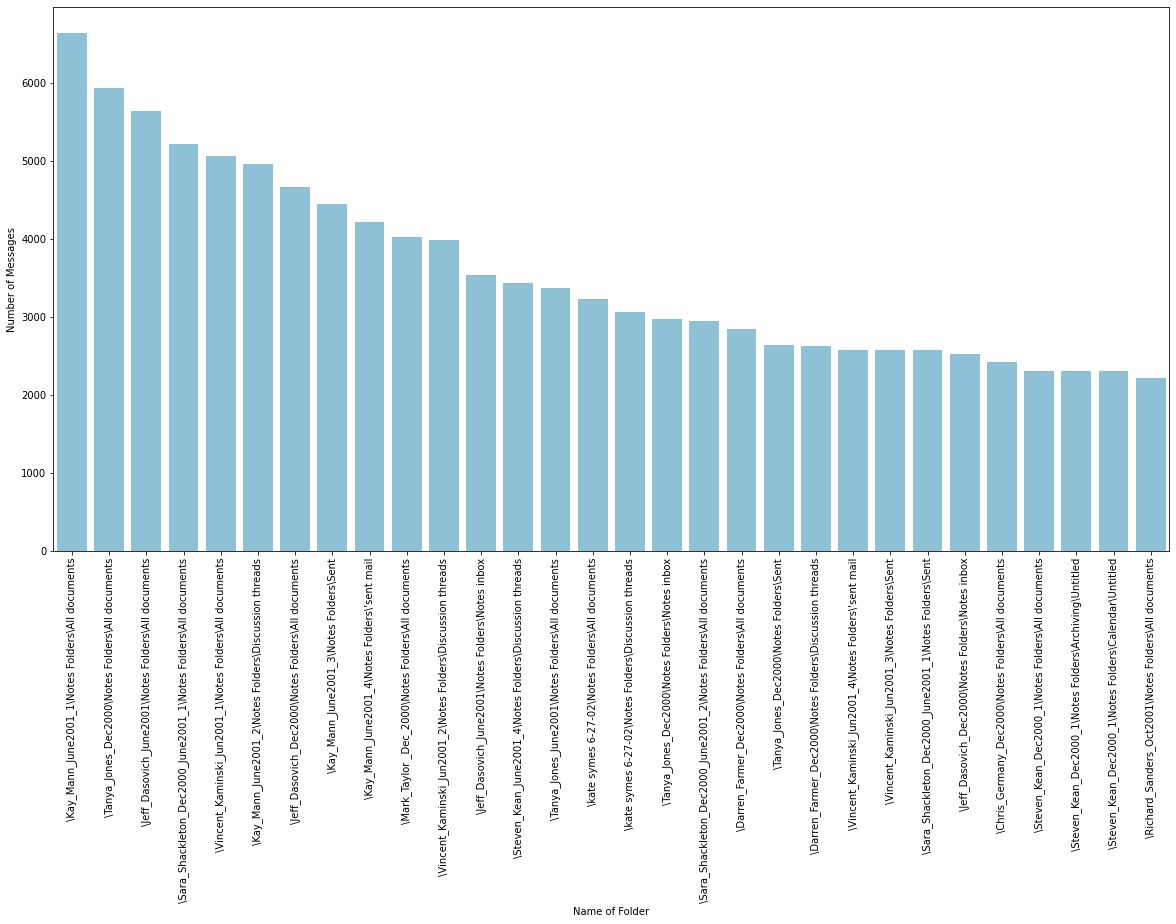

In [ ]:

#Additional dataframe that includes word counts
num_folders = emails["X-Folder"].value_counts()
folder_paths = num_folders.index
df_plot = pd.DataFrame(num_folders, columns = ["X-Folder"])
df_plot["Folder Names"] = folder_paths

def plot_bars(df, x_vals, y_vals, size, color, orientation, lbl_y,lbl_x, font_scale, rotation):
  '''
  takes in parameters and plots barplot
  '''
  fig, axis = plt.subplots(figsize = size)
  sns.set_color_codes("muted")
  sns.barplot(x_vals, y_vals, data = df, color = color, orient = orientation)
  axis.set(ylabel = lbl_y, xlabel = lbl_x)
  sns.set(font_scale = font_scale)
  plt.xticks(rotation = rotation) 


top_n = 30    

plot_bars(df_plot[:top_n], x_vals = "Folder Names",y_vals = "X-Folder", size = (20, 10), color = 'c', orientation = 'v', lbl_y = "Number of Messages", lbl_x = "Name of Folder", font_scale = 1.3, rotation = 90)
plt.savefig("gdrive/My Drive/Enron/folders.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


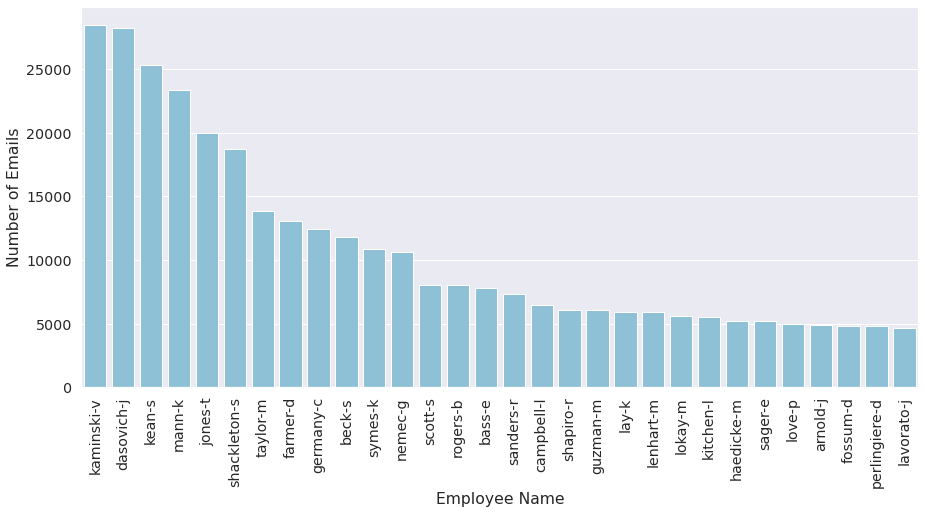

In [ ]:
num_email_emp = emails["employee"].value_counts()
emp_names = num_email_emp.index
df_plot = pd.DataFrame(num_email_emp)
df_plot.rename(columns = {"employee": "number of emails"}, inplace = True)
df_plot["Employee Names"] = emp_names


plot_bars(df_plot[:top_n], x_vals = "Employee Names" ,y_vals = "number of emails", size = (15, 7), color = 'c', orientation = 'v', lbl_y = "Number of Emails", lbl_x = "Employee Name", font_scale = 1.3, rotation = 90)
plt.savefig("gdrive/My Drive/Enron/employee.png")
plt.show()

In [ ]:
# # Convert date column to datetime 
# emails["Date"] = pd.to_datetime(emails["Date"])
# print(emails.iloc[:1]["Date"])

In [ ]:
def clean_folder_path(paths):
  '''
  takes in folder paths and cleans unecessary names
  '''
  out = []
  
  for path in paths:
      
    if path != None and path != '':
      path = path.split("\\")[-1].lower()
      out.append(path)
    
    else:
      out.append(np.nan)

  return out     
emails["X-Folder"] = clean_folder_path(emails["X-Folder"])   
print('Cleanded up folder names')

Cleanded up folder names


In [ ]:
# Folders we can filter out
folders_to_remove = ["all documents", "deleted items", "discussion threads",
                     "sent", "deleted Items", "inbox",
                   "sent items", "'sent mail", "untitled", "notes inbox",
                    "junk file", "e-mail bin", "tw-commercial group",
                     "schedule crawler", "tufco"]#, "calendar"]

#Remove irrelevant folders from dataframe
emails = emails.loc[~emails['X-Folder'].isin(folders_to_remove)]

In [ ]:
meeting_index_list = emails.loc[emails["X-Folder"] == 'meetings'].index.values.tolist()
calendar_index_list = emails.loc[emails["X-Folder"] == 'calendar'].index.values.tolist()

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [ ]:
n_samples = 5
meeting_random_sample = random.sample(meeting_index_list,n_samples)
calendar_random_sample = random.sample(calendar_index_list,n_samples)

In [ ]:
for i in meeting_random_sample:
  print('MEETING INDEX:',i)
  print('----------------------------------------------------------------')
  print(emails.loc[emails["X-Folder"] == 'meetings']['Message-Body'][i])
  print('----------------------------------------------------------------')
  print()

MEETING INDEX: 34538
----------------------------------------------------------------
calendar entry:	appointment

description:
	koch late pays attendees: (kathy w., larry b., neil shaw) lynn's office

date:		9/21/2000
time:		10:30 am - 11:00 am (central standard time)

chairperson:	outlook migration team

detailed description:
----------------------------------------------------------------

MEETING INDEX: 34348
----------------------------------------------------------------
calendar entry:	appointment

description:
	new contract system - eb47c2

date:		4/20/2001
time:		10:30 am - 12:30 pm (central standard time)

chairperson:	outlook migration team

detailed description:
----------------------------------------------------------------

MEETING INDEX: 506225
----------------------------------------------------------------
calendar entry:	reminder

description:
	monica - vacation

date:		10/5/2000
time:		8:00 am (central standard time)

chairperson:	outlook migration team

detailed de

In [ ]:
for i in calendar_random_sample:
  print('CALENDAR INDEX:',i)
  print('----------------------------------------------------------------')
  print(emails.loc[emails["X-Folder"] == 'calendar']['Message-Body'][i])
  print('----------------------------------------------------------------')
  print()

CALENDAR INDEX: 498946
----------------------------------------------------------------
teresa wright x35430
----------------------------------------------------------------

CALENDAR INDEX: 51844
----------------------------------------------------------------
shelley,
i would like to get together to talk about my professional development and possible opportunities.  thank you.
----------------------------------------------------------------

CALENDAR INDEX: 24876
----------------------------------------------------------------


breakfast, work, lunch, work, dinner, work
----------------------------------------------------------------

CALENDAR INDEX: 24973
----------------------------------------------------------------


8:35a 	arrive @ enron kids' center/cont'l breakfast

8:45a	childcare update

8:50a	director's welcome

9:00a	tour

9:30a	depart for enron bldg.
----------------------------------------------------------------

CALENDAR INDEX: 503882
--------------------------------

In [ ]:
print(emails.iloc[:]["X-Folder"].value_counts())

personal                  2642
attachments               2026
meetings                  1872
calendar                  1732
logistics                 1192
                          ... 
competition messages         1
sun devil expansion          1
demarc allocation            1
tw throughput analysis       1
investing                    1
Name: X-Folder, Length: 1767, dtype: int64


In [ ]:
# email_count = dict(emails["employee"].value_counts())
# reduced_emails = [key for key, val in email_count.items() if val >= 2000]
# emails = emails.loc[emails['employee'].isin(reduced_emails)]
# print(emails["employee"].value_counts())

In [ ]:
emails.isnull().sum()

file             0
message          0
Message-Body     0
X-From          29
employee         0
Date             0
Subject          0
X-To            29
X-Folder        29
dtype: int64

In [ ]:
emails.dropna(inplace = True)
#print("Rows with missing values have been removed")
emails.isnull().sum()

file            0
message         0
Message-Body    0
X-From          0
employee        0
Date            0
Subject         0
X-To            0
X-Folder        0
dtype: int64

In [ ]:
def remove_folders(emails, n):
    # Returns the folders containing more than 'n' number of e-mails
    email_count = dict(emails["X-Folder"].value_counts())
    small_folders = [key for key, val in email_count.items() if val <= n]
    emails = emails.loc[~emails['X-Folder'].isin(small_folders)]
    return emails

In [ ]:
new_emails = remove_folders(emails,500)

In [ ]:
print(new_emails.iloc[:]["X-Folder"].value_counts())

personal              2642
attachments           2026
meetings              1872
calendar              1732
logistics             1192
california            1052
bill williams iii     1022
deal discrepancies     897
management             802
esvl                   715
resumes                609
ces                    576
online trading         573
junk                   560
ooc                    511
Name: X-Folder, dtype: int64


In [ ]:
#new_emails.loc[emails["X-Folder"] == 'ces']['Message-Body']

In [ ]:
new_emails['New_folder'] = 'other'
new_emails.loc[new_emails["X-Folder"] == 'meetings', 'New_folder'] = 'meeting relevant'
new_emails.loc[new_emails["X-Folder"] == 'calendar', 'New_folder'] = 'meeting relevant'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [ ]:
new_emails['New_folder']

6345                 other
6346                 other
6347                 other
6348                 other
6349                 other
                ...       
516848    meeting relevant
516849    meeting relevant
516850    meeting relevant
516851    meeting relevant
516852    meeting relevant
Name: New_folder, Length: 16781, dtype: object

In [ ]:
print(new_emails.iloc[:]["New_folder"].value_counts())

other               13177
meeting relevant     3604
Name: New_folder, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


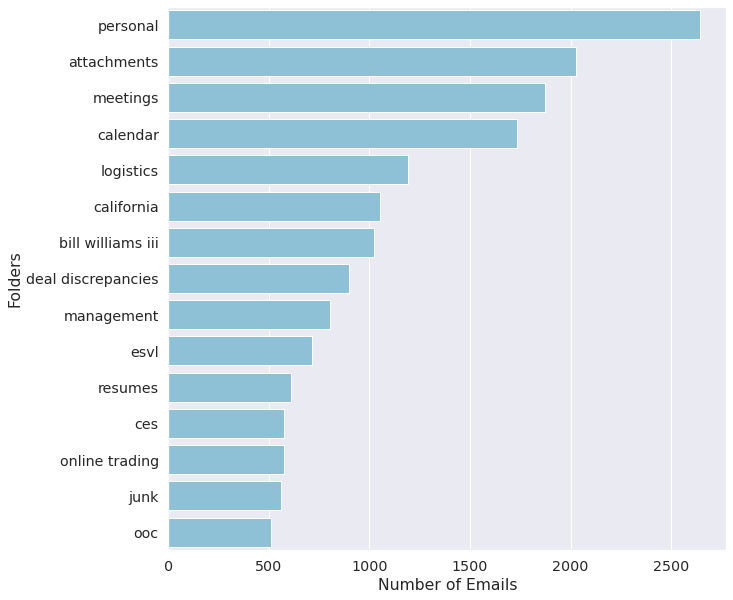

In [ ]:
mail_count = new_emails["X-Folder"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"X-Folder": "Count"}, inplace = True)
count["Folders"] = indices
plot_bars(df = count[:top_n], x_vals= "Count", y_vals = "Folders", size = (10, 10), color = 'c', orientation = 'h', lbl_y = "Folders", lbl_x = "Number of Emails", font_scale = 0.8, rotation = 0)
plt.savefig("gdrive/My Drive/Enron/folder1.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


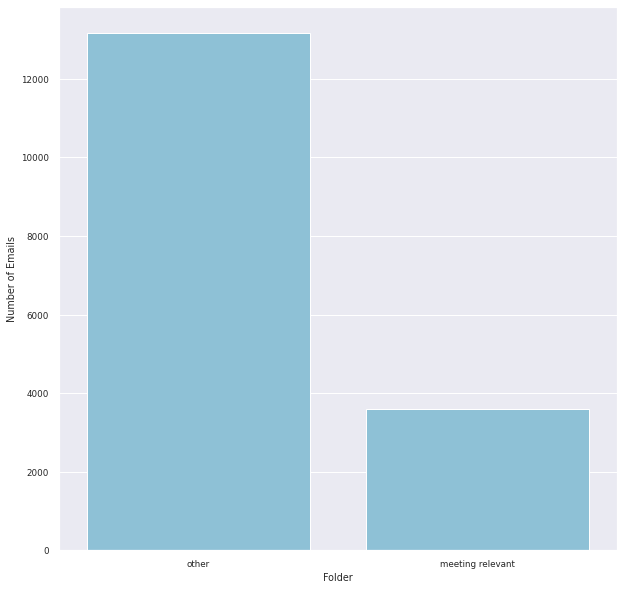

In [ ]:
mail_count = new_emails["New_folder"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"New_folder": "Count"}, inplace = True)
count["Folders"] = indices
plot_bars(df = count[:top_n], x_vals = "Folders", y_vals = "Count", size = (10, 10), color = 'c', orientation = 'v', lbl_y = "Number of Emails", lbl_x = "Folder", font_scale = 1.5, rotation = 0)
plt.savefig("gdrive/My Drive/Enron/folder0.png")
plt.show()

In [ ]:
meeting_count = len(new_emails[new_emails['New_folder'] == 'meeting relevant'])
other_count = len(new_emails[new_emails['New_folder'] == 'other'])

In [ ]:
print(meeting_count)
print(other_count)
ratio = meeting_count / other_count
print(ratio)
fraction = 1 - round(ratio, 1)
fraction

3604
13177
0.2735068680276239


0.7

In [ ]:
new_emails_b = new_emails.copy(deep=True)

In [ ]:
new_emails_b = new_emails_b.drop(new_emails_b[new_emails['New_folder'] == 'other'].sample(frac= fraction).index)

In [ ]:
print(new_emails_b.iloc[:]["New_folder"].value_counts())

other               3953
meeting relevant    3604
Name: New_folder, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


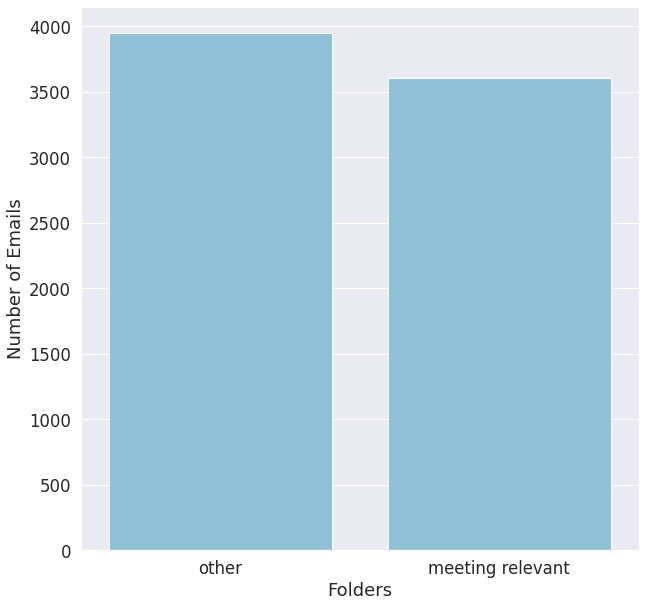

In [ ]:
mail_count = new_emails_b["New_folder"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"New_folder": "Count"}, inplace = True)
count["Folders"] = indices
plot_bars(df = count[:top_n], x_vals = "Folders", y_vals = "Count", size = (10, 10), color = 'c', orientation = 'v', lbl_y = "Number of Emails", lbl_x = "Folders", font_scale = 1.5, rotation = 0)
plt.savefig("gdrive/My Drive/Enron/folder2.png")
plt.show()

In [ ]:
new_emails_b['New_folder'] = pd.Categorical(new_emails_b['New_folder'])
new_emails_b['class'] = new_emails_b['New_folder'].cat.codes

In [ ]:
# new_emails_b.to_csv('data.csv')
# !cp data.csv "gdrive/My Drive/Enron"

In [ ]:
new_emails_b

,file,message,Message-Body,X-From,employee,Date,Subject,X-To,X-Folder,New_folder,class
8947,badeer-r/california/11.,"Message-ID: <1015693.1075863594681.JavaMail.evans@thyme>\nDate: Wed, 16 Aug 2000 06:19:00 -0700 ...",update on inter-sc trades adjustment bid project timeline\nmarket participants:\n\nmarket partic...,CRCommunications <CRCommunications@caiso.com>,badeer-r,"Wed, 16 Aug 2000 06:19:00 -0700 (PDT)",CAISO NOTIFICATION - UPDATE ON INTER-SC TRADES ADJUSTMENT BID PRO\n JECT TIMELINE,ISO Market Participants <IMCEAEX-_O=CAISO_OU=CORPORATE_CN=DISTRIBUTION+20LISTS_CN=ISO+20MARKET+2...,california,other,1
8948,badeer-r/california/12.,"Message-ID: <25111307.1075863594703.JavaMail.evans@thyme>\nDate: Wed, 16 Aug 2000 06:17:00 -0700...",an update of the summer 2001 preparedness mif presentation has been posted\non the website. the ...,"""Happ, Susan"" <SHapp@caiso.com>",badeer-r,"Wed, 16 Aug 2000 06:17:00 -0700 (PDT)",Update to the MIF Meeting Presentations on the ISO Website,ISO Market Participants <IMCEAEX-_O=CAISO_OU=CORPORATE_CN=DISTRIBUTION+20LISTS_CN=ISO+20MARKET+2...,california,other,1
8949,badeer-r/california/13.,"Message-ID: <31650933.1075863594727.JavaMail.evans@thyme>\nDate: Tue, 15 Aug 2000 04:38:00 -0700...",the presentations from the market issues forum meeting of august 9 are now\navailable at our web...,"""Happ, Susan"" <SHapp@caiso.com>",badeer-r,"Tue, 15 Aug 2000 04:38:00 -0700 (PDT)",MIF Presentations,ISO Market Participants <IMCEAEX-_O=CAISO_OU=CORPORATE_CN=DISTRIBUTION+20LISTS_CN=ISO+20MARKET+2...,california,other,1
8950,badeer-r/california/14.,"Message-ID: <18832500.1075863594748.JavaMail.evans@thyme>\nDate: Tue, 15 Aug 2000 04:08:00 -0700...","the lars meeting, scheduled for august 21, will be at ca iso in folsom,\nconference room 101a 1a...","""Happ, Susan"" <SHapp@caiso.com>",badeer-r,"Tue, 15 Aug 2000 04:08:00 -0700 (PDT)",LARS Meeting Update,ISO Market Participants <IMCEAEX-_O=CAISO_OU=CORPORATE_CN=DISTRIBUTION+20LISTS_CN=ISO+20MARKET+2...,california,other,1
8951,badeer-r/california/15.,"Message-ID: <32427124.1075863594770.JavaMail.evans@thyme>\nDate: Fri, 11 Aug 2000 09:14:00 -0700...",market participants:\n\nattached please find the agendas for the upcoming cmr stakeholder meetin...,"""Grant, Colleen"" <CGrant@caiso.com>",badeer-r,"Fri, 11 Aug 2000 09:14:00 -0700 (PDT)",CAISO NOTICE: AGENDA for CMR Stakeholder Meeting August 16-18,ISO Market Participants <IMCEAEX-_O=CAISO_OU=CORPORATE_CN=DISTRIBUTION+20LISTS_CN=ISO+20MARKET+2...,california,other,1
...,...,...,...,...,...,...,...,...,...,...,...
516848,zufferli-j/calendar/3.,"Message-ID: <18025482.1075842024808.JavaMail.evans@thyme>\nDate: Mon, 5 Nov 2001 10:49:19 -0800 ...",dial in number: 216-0900\npasscode: 5879#\nchair: rob hemstock\n\nalso participating will be ...,"Crawford, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN=SCRAWFO3>",zufferli-j,"Mon, 5 Nov 2001 10:49:19 -0800 (PST)",Duke/Westcoast Transaction,"Crawford, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Scrawfo3>, Milnthorp, Rob </O=ENRON/OU=NA/CN=R...",calendar,meeting relevant,0
516849,zufferli-j/calendar/4.,"Message-ID: <24868483.1075842024831.JavaMail.evans@thyme>\nDate: Wed, 31 Oct 2001 10:20:31 -0800...",sent on behalf of peter keohane:\n\nalso participating will be ron deyholos and george vegh of d...,"Crawford, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN=SCRAWFO3>",zufferli-j,"Wed, 31 Oct 2001 10:20:31 -0800 (PST)",Duke/Westcoast Transaction,"Crawford, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Scrawfo3>, Milnthorp, Rob </O=ENRON/OU=NA/CN=R...",calendar,meeting relevant,0
516850,zufferli-j/calendar/5.,"Message-ID: <10596074.1075842024854.JavaMail.evans@thyme>\nDate: Tue, 2 Oct 2001 10:16:42 -0700 ...",would like to grab an hour to discuss different go-forward edcc/ecc pricing scenarios.,"Cross, Darren </O=ENRON/OU=NA/CN=RECIPIENTS/CN=DCROSS2>",zufferli-j,"Tue, 2 Oct 2001 10:16:42 -0700 (PDT)",Updated: EDCC/ECC Pricing Discussion,"Cross, Darren </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Dcross2>, Campbell, S

In [ ]:
# email_list = list(new_emails_b['Message-Body'])
# labels = list(new_emails_b['class'])

# unique_labels = list(new_emails_b['class'].unique())

In [ ]:
df_meeting = new_emails_b[new_emails_b['class'] == 0]
df_other = new_emails_b[new_emails_b['class'] == 1]

In [ ]:
meetings_list = df_meeting['Message-Body'].tolist()
others_list = df_other['Message-Body'].tolist()

In [ ]:
filtered_meeting = ("").join(meetings_list) #convert the list into a string of spam
filtered_meeting = filtered_meeting.lower()

In [ ]:
filtered_other = ("").join(others_list) #convert the list into a string of spam
filtered_other = filtered_other.lower()

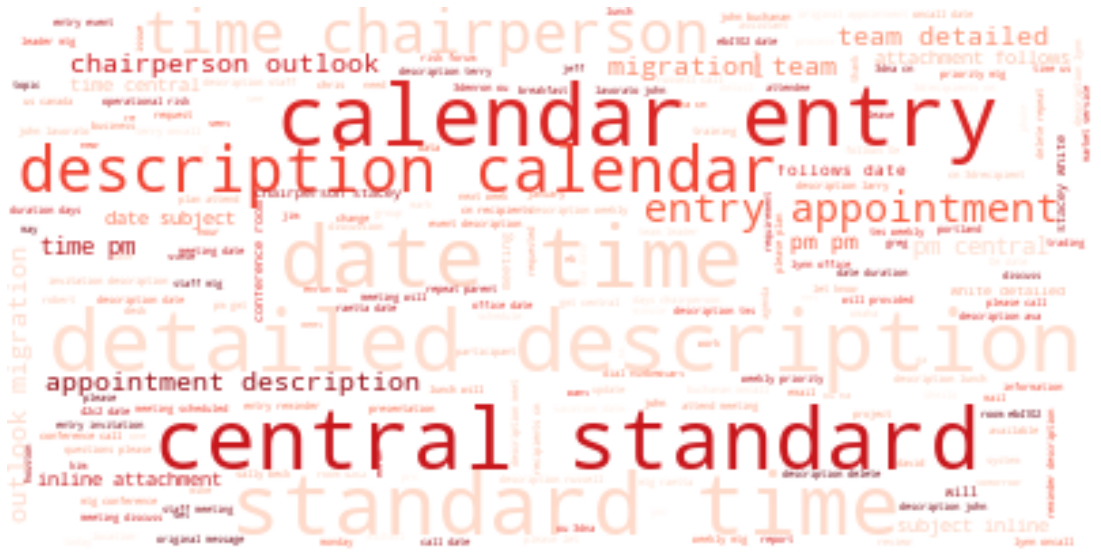

In [ ]:

#create and generate a word cloud image
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Reds").generate(filtered_meeting)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)
plt.savefig("gdrive/My Drive/Enron/cloud1.png")
plt.show()

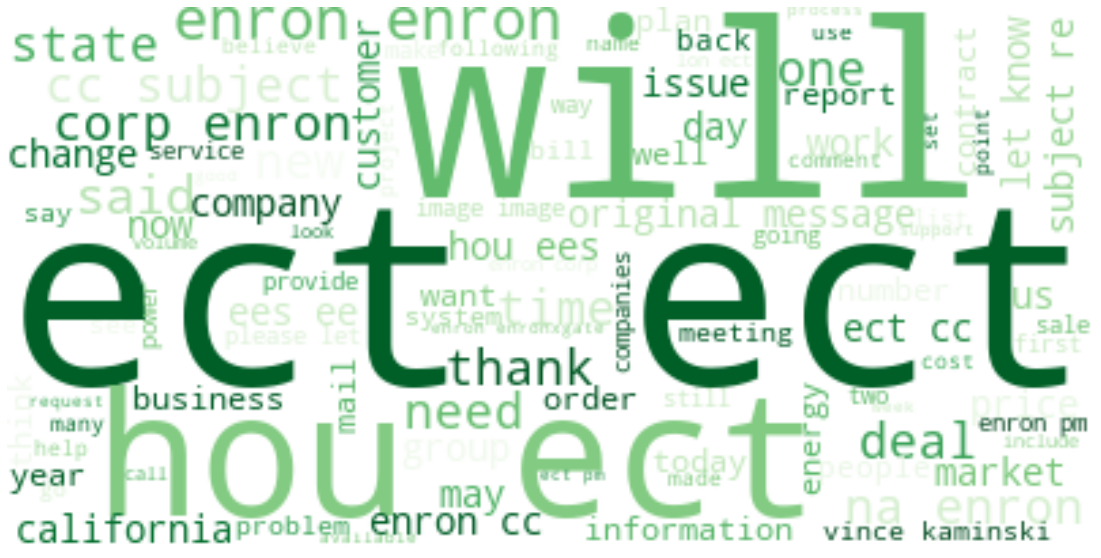

In [ ]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Greens").generate(filtered_other)
 
# Display the generated image

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)
plt.savefig("gdrive/My Drive/Enron/cloud2.png")
plt.show()